In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import netCDF4 as nc
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import numpy as np
#import pandas as pd
import itertools
#from os import path
import math
import pandas as pd
import xarray as xr
import glob
import wrf
from wrf import getvar, interplevel,interpz3d

In [10]:
#calculate the droplet number concentration along IOP22-UWKA flight path.

#read in wrf output files
#wrfout_dir='/glade/u/home/sisichen/scratch/WRF_SNOWIE/ERA5_run/wrfout_900m_originalCCN/'
wrfout_dir='/glade/u/home/sisichen/scratch/WRF_SNOWIE/ERA5_run/wrfout_900m_03CCN/'
wrfout_filelist=glob.glob(wrfout_dir+'wrfout_*')
ntotal=0
for wrfout_file in wrfout_filelist:
    if int(wrfout_file[91:93])>=14 and int(wrfout_file[91:93])<17:
        ntotal=ntotal+1
nfile=0
print('Read wrfout files...')
for wrfout_file in wrfout_filelist:
    if int(wrfout_file[91:93])>=14 and int(wrfout_file[91:93])<17:
        ncfile = Dataset(wrfout_file,mode='r')
        if nfile==0:
            #calculate the grid index of the sw & ne corner of the selected region
            x_min=-116.60
            x_max=-115.28
            y_min=44.11
            y_max=44.3
            xy_sw1=wrf.ll_to_xy(ncfile,y_min,x_min).data
            xy_ne1=wrf.ll_to_xy(ncfile,y_max,x_max).data
            x_min=-116.8
            x_max=-116.2
            y_min=43.45
            y_max=44.21
            xy_sw2=wrf.ll_to_xy(ncfile,y_min,x_min).data
            xy_ne2=wrf.ll_to_xy(ncfile,y_max,x_max).data
        p = getvar(ncfile, "pressure")
        ht = getvar(ncfile, "z", msl=True,units="m")
        tk = getvar(ncfile,"tk")
        rho=p*100/(283.14*tk)
        qncloud=getvar(ncfile,"QNCLOUD")
        qcloud=getvar(ncfile,"QCLOUD")*1e3 #lwc g/kg
        ncloud=qncloud*rho/1e6
        #ht_500 = interpz3d(ht, p, 500.0)
        #interpolate to height MSL
        qcloud_4876 = interplevel(qcloud, ht, 4876.0)#16,000feet
        qcloud_4572 = interplevel(qcloud, ht, 4572.0)
        ncloud_4876 = interplevel(ncloud, ht, 4876.0)#16,000feet
        ncloud_4572 = interplevel(ncloud, ht, 4572.0)

        #get average droplet number concentration over the region
        ncloud_region1=ncloud_4876[xy_sw1[1]-1:xy_ne1[1]+1,xy_sw1[0]-1:xy_ne1[0]+1].data
        ncloud_region1=ncloud_region1.reshape(ncloud_region1.size,)
        ncloud_region2=ncloud_4572[xy_sw1[1]-1:xy_ne1[1]+1,xy_sw1[0]-1:xy_ne1[0]+1].data
        ncloud_region2=ncloud_region2.reshape(ncloud_region2.size,)
        ncloud_region3=ncloud_4572[xy_sw2[1]-1:xy_ne2[1]+1,xy_sw2[0]-1:xy_ne2[0]+1].data
        ncloud_region3=ncloud_region3.reshape(ncloud_region3.size,)
        ncloud_regions=np.hstack((ncloud_region1,ncloud_region2,ncloud_region3))
        
        
        #get LWC over the region
        qcloud_region1=qcloud_4876[xy_sw1[1]-1:xy_ne1[1]+1,xy_sw1[0]-1:xy_ne1[0]+1].data
        qcloud_region1=qcloud_region1.reshape(qcloud_region1.size,)
        qcloud_region2=qcloud_4572[xy_sw1[1]-1:xy_ne1[1]+1,xy_sw1[0]-1:xy_ne1[0]+1].data
        qcloud_region2=qcloud_region2.reshape(qcloud_region2.size,)
        qcloud_region3=qcloud_4572[xy_sw2[1]-1:xy_ne2[1]+1,xy_sw2[0]-1:xy_ne2[0]+1].data
        qcloud_region3=qcloud_region3.reshape(qcloud_region3.size,)
        qcloud_regions=np.hstack((qcloud_region1,qcloud_region2,qcloud_region3))
        
        #use lower limit N>3.0/cc to filter out the datapoint
        cdnc_min=3.0
        non_zero_ncloud1=ncloud_region1[ncloud_region1>=cdnc_min]
        non_zero_ncloud2=ncloud_region2[ncloud_region2>=cdnc_min]
        non_zero_ncloud3=ncloud_region3[ncloud_region3>=cdnc_min]
        non_zero_nclouds=ncloud_regions[ncloud_regions>=cdnc_min]
        
        positive_qcloud1=qcloud_region1[ncloud_region1>=cdnc_min]
        positive_qcloud2=qcloud_region2[ncloud_region2>=cdnc_min]
        positive_qcloud3=qcloud_region3[ncloud_region3>=cdnc_min]
        positive_qclouds=qcloud_regions[ncloud_regions>=cdnc_min]
        
        if nfile == 0:
            NCLOUD_R1_series=non_zero_ncloud1
            NCLOUD_R2_series=non_zero_ncloud2
            NCLOUD_R3_series=non_zero_ncloud3
            NCLOUD_ALL_series=non_zero_nclouds
            
            QCLOUD_R1_series=positive_qcloud1
            QCLOUD_R2_series=positive_qcloud2
            QCLOUD_R3_series=positive_qcloud3
            QCLOUD_ALL_series=positive_qclouds
        else:
            NCLOUD_R1_series=np.append(NCLOUD_R1_series,non_zero_ncloud1)
            NCLOUD_R2_series=np.append(NCLOUD_R2_series,non_zero_ncloud2)
            NCLOUD_R3_series=np.append(NCLOUD_R3_series,non_zero_ncloud3)
            NCLOUD_ALL_series=np.append(NCLOUD_ALL_series,non_zero_nclouds)
            
            QCLOUD_R1_series=np.append(QCLOUD_R1_series,positive_qcloud1)
            QCLOUD_R2_series=np.append(QCLOUD_R2_series,positive_qcloud2)
            QCLOUD_R3_series=np.append(QCLOUD_R3_series,positive_qcloud3)
            QCLOUD_ALL_series=np.append(QCLOUD_ALL_series,positive_qclouds)
        #np.nonzero(ncloud_select_region)
        nfile=nfile+1
        print('processed ',nfile,' out of',ntotal,'  files')
print('Finished')

Read wrfout files...
processed  1  out of 18   files
processed  2  out of 18   files
processed  3  out of 18   files
processed  4  out of 18   files


/glade/work/sisichen/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/sisichen/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/sisichen/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/sisichen/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater_equal


processed  5  out of 18   files
processed  6  out of 18   files
processed  7  out of 18   files
processed  8  out of 18   files
processed  9  out of 18   files
processed  10  out of 18   files
processed  11  out of 18   files
processed  12  out of 18   files
processed  13  out of 18   files
processed  14  out of 18   files
processed  15  out of 18   files
processed  16  out of 18   files
processed  17  out of 18   files
processed  18  out of 18   files
Finished


In [9]:
NCLOUD_R3_series.size

2832

In [11]:
#calculate statistics of CDNC over the three selected regions
print('calculate the all three region average')
non_zero_ncloud=NCLOUD_ALL_series#np.append(non_zero_ncloud1,non_zero_ncloud2)
max_ncloud=non_zero_ncloud.max()
mean_ncloud=non_zero_ncloud.mean()
min_ncloud=non_zero_ncloud.min()
n5=np.percentile(non_zero_ncloud, 5) 
n25=np.percentile(non_zero_ncloud, 25) 
n50=np.percentile(non_zero_ncloud, 50)
n75=np.percentile(non_zero_ncloud, 75)
n95=np.percentile(non_zero_ncloud, 95) 
print('min, max, mean')
print(min_ncloud,max_ncloud,mean_ncloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

print('calculate the region 1 average')
non_zero_ncloud=NCLOUD_R1_series#np.append(non_zero_ncloud1,non_zero_ncloud2)
max_ncloud=non_zero_ncloud.max()
mean_ncloud=non_zero_ncloud.mean()
min_ncloud=non_zero_ncloud.min()
n5=np.percentile(non_zero_ncloud, 5) 
n25=np.percentile(non_zero_ncloud, 25) 
n50=np.percentile(non_zero_ncloud, 50)
n75=np.percentile(non_zero_ncloud, 75)
n95=np.percentile(non_zero_ncloud, 95) 
print('min, max, mean')
print(min_ncloud,max_ncloud,mean_ncloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

print('calculate the region 2 average')
non_zero_ncloud=NCLOUD_R2_series#np.append(non_zero_ncloud1,non_zero_ncloud2)
max_ncloud=non_zero_ncloud.max()
mean_ncloud=non_zero_ncloud.mean()
min_ncloud=non_zero_ncloud.min()
n5=np.percentile(non_zero_ncloud, 5) 
n25=np.percentile(non_zero_ncloud, 25) 
n50=np.percentile(non_zero_ncloud, 50)
n75=np.percentile(non_zero_ncloud, 75)
n95=np.percentile(non_zero_ncloud, 95) 
print('min, max, mean')
print(min_ncloud,max_ncloud,mean_ncloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

print('calculate the region 3 average')
non_zero_ncloud=NCLOUD_R3_series#np.append(non_zero_ncloud1,non_zero_ncloud2)
max_ncloud=non_zero_ncloud.max()
mean_ncloud=non_zero_ncloud.mean()
min_ncloud=non_zero_ncloud.min()
n5=np.percentile(non_zero_ncloud, 5) 
n25=np.percentile(non_zero_ncloud, 25) 
n50=np.percentile(non_zero_ncloud, 50)
n75=np.percentile(non_zero_ncloud, 75)
n95=np.percentile(non_zero_ncloud, 95) 
print('min, max, mean')
print(min_ncloud,max_ncloud,mean_ncloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

calculate the all three region average
min, max, mean
3.000642 107.147964 39.78603
5%, 25%, 50%, 75%, 95%
7.952978134155273 24.345317840576172 40.67108917236328 54.862409591674805 70.82990264892578
calculate the region 1 average
min, max, mean
3.0017323 94.704506 33.047
5%, 25%, 50%, 75%, 95%
4.758941173553467 13.470256805419922 28.805506706237793 51.3762321472168 71.55316505432128
calculate the region 2 average
min, max, mean
3.0030472 107.147964 44.37999
5%, 25%, 50%, 75%, 95%
6.457740306854248 22.19998788833618 46.984352111816406 65.95393562316895 77.95695686340332
calculate the region 3 average
min, max, mean
3.000642 107.147964 38.78563
5%, 25%, 50%, 75%, 95%
8.927286911010743 25.132930755615234 39.90169906616211 52.927215576171875 65.07912139892578


In [12]:
#calculate statistics of LWC over the three selected regions
print('calculate the all three region average')
non_zero_qcloud=QCLOUD_ALL_series#np.append(non_zero_qcloud1,non_zero_qcloud2)
max_qcloud=non_zero_qcloud.max()
mean_qcloud=non_zero_qcloud.mean()
min_qcloud=non_zero_qcloud.min()
n5=np.percentile(non_zero_qcloud, 5) 
n25=np.percentile(non_zero_qcloud, 25) 
n50=np.percentile(non_zero_qcloud, 50)
n75=np.percentile(non_zero_qcloud, 75)
n95=np.percentile(non_zero_qcloud, 95) 
print('min, max, mean')
print(min_qcloud,max_qcloud,mean_qcloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

print('calculate the region 1 average')
non_zero_qcloud=QCLOUD_R1_series#np.append(non_zero_qcloud1,non_zero_qcloud2)
max_qcloud=non_zero_qcloud.max()
mean_qcloud=non_zero_qcloud.mean()
min_qcloud=non_zero_qcloud.min()
n5=np.percentile(non_zero_qcloud, 5) 
n25=np.percentile(non_zero_qcloud, 25) 
n50=np.percentile(non_zero_qcloud, 50)
n75=np.percentile(non_zero_qcloud, 75)
n95=np.percentile(non_zero_qcloud, 95) 
print('min, max, mean')
print(min_qcloud,max_qcloud,mean_qcloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

print('calculate the region 2 average')
non_zero_qcloud=QCLOUD_R2_series#np.append(non_zero_qcloud1,non_zero_qcloud2)
max_qcloud=non_zero_qcloud.max()
mean_qcloud=non_zero_qcloud.mean()
min_qcloud=non_zero_qcloud.min()
n5=np.percentile(non_zero_qcloud, 5) 
n25=np.percentile(non_zero_qcloud, 25) 
n50=np.percentile(non_zero_qcloud, 50)
n75=np.percentile(non_zero_qcloud, 75)
n95=np.percentile(non_zero_qcloud, 95) 
print('min, max, mean')
print(min_qcloud,max_qcloud,mean_qcloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

print('calculate the region 3 average')
non_zero_qcloud=QCLOUD_R3_series#np.append(non_zero_qcloud1,non_zero_qcloud2)
max_qcloud=non_zero_qcloud.max()
mean_qcloud=non_zero_qcloud.mean()
min_qcloud=non_zero_qcloud.min()
n5=np.percentile(non_zero_qcloud, 5) 
n25=np.percentile(non_zero_qcloud, 25) 
n50=np.percentile(non_zero_qcloud, 50)
n75=np.percentile(non_zero_qcloud, 75)
n95=np.percentile(non_zero_qcloud, 95) 
print('min, max, mean')
print(min_qcloud,max_qcloud,mean_qcloud)
print('5%, 25%, 50%, 75%, 95%')
print(n5,n25,n50,n75,n95)

calculate the all three region average
min, max, mean
6.2130694e-06 1.3548512 0.28569025
5%, 25%, 50%, 75%, 95%
0.009303673170506954 0.06179461069405079 0.192432701587677 0.4649707078933716 0.8144104182720184
calculate the region 1 average
min, max, mean
1.10356095e-05 0.50663406 0.07371895
5%, 25%, 50%, 75%, 95%
0.002764665591530503 0.015487933997064829 0.0431801863014698 0.1066665481775999 0.246237102150917
calculate the region 2 average
min, max, mean
1.6647326e-05 1.21782 0.13967738
5%, 25%, 50%, 75%, 95%
0.004396598436869681 0.026927053928375244 0.08515158295631409 0.19798078760504723 0.4610048830509186
calculate the region 3 average
min, max, mean
6.2130694e-06 1.3548512 0.33361882
5%, 25%, 50%, 75%, 95%
0.014486634172499183 0.08788640052080154 0.26207199692726135 0.5447462797164917 0.8439029097557067


In [3]:
#read the ncloud data at 15k ft and 16k ft levels

wrfout_data1 = '/glade/u/home/sisichen/scratch/WRF_SNOWIE/ERA5_run/wrfout_900m/wrfout_d01_2017-03-09_16:00:00'
wrfout_data2 = '/glade/u/home/sisichen/scratch/WRF_SNOWIE/ERA5_run/wrfout_300m/wrfout_d01_2017-03-09_16:00:00'
ncfile1 = Dataset(wrfout_data1,mode='r')
p1 = getvar(ncfile1, "pressure")
ht1 = getvar(ncfile1, "z", msl=True,units="m")
tk1 = getvar(ncfile1,"tk")
rho1=p1*100/(283.14*tk1)
qncloud1=getvar(ncfile1,"QNCLOUD")
ncloud1=qncloud1*rho1/1e6
#ht_500 = interpz3d(ht, p, 500.0)
#interpolate to height MSL
ncloud1_level2 = interplevel(ncloud1, ht1, 4876.0)#16,000feet
ncloud1_level1 = interplevel(ncloud1, ht1, 4572.0)# 15 k ft

ncfile2 = Dataset(wrfout_data2,mode='r')
p2 = getvar(ncfile2, "pressure")
ht2 = getvar(ncfile2, "z", msl=True,units="m")
tk2 = getvar(ncfile2,"tk")
rho2=p2*100/(283.14*tk2)
qncloud2=getvar(ncfile2,"QNCLOUD")
ncloud2=qncloud2*rho2/1e6
#ht_500 = interpz3d(ht, p, 500.0)
#interpolate to height MSL
ncloud2_level2 = interplevel(ncloud2, ht2, 4876.0)#16,000feet
ncloud2_level1 = interplevel(ncloud2, ht2, 4572.0)# 15 k ft

In [4]:
#plot the flight path and selected regions
def get_plot_element(infile):
    '''
    convert the lat, lon information to the 
    x, y coordinates in the cartopy domain.
    '''
    rootgroup = nc.Dataset(infile, 'r')
    p = wrf.getvar(rootgroup, 'RAINNC')
    #lats, lons = wrf.latlon_coords(p)
    cart_proj = wrf.get_cartopy(p)
    xlim = wrf.cartopy_xlim(p)
    ylim = wrf.cartopy_ylim(p)
    rootgroup.close()
    return cart_proj, xlim, ylim

def coord_transform(lon,lon_min,lon_max,xlim_d01):
    x=(lon-lon_min)/(lon_max-lon_min)*(xlim_d01[1]-xlim_d01[0])+xlim_d01[0]
    return x

Text(0, 283027.5959157248, 'T=16:00:00 UTC, Z = 15,000 Feet')

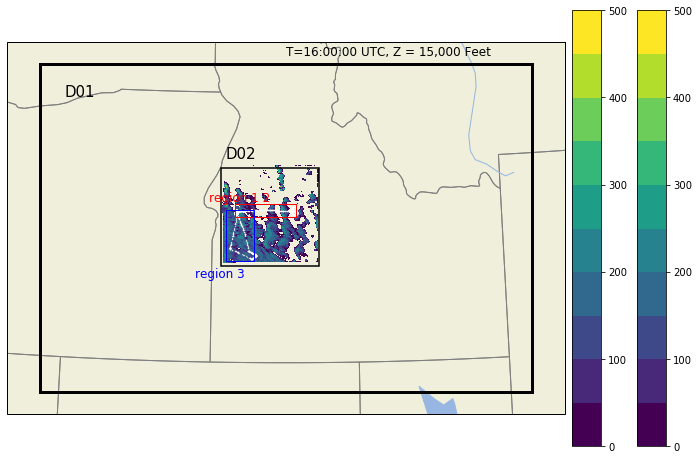

In [58]:
wrfout_d01 = '/glade/u/home/sisichen/scratch/WRF_SNOWIE/ERA5_run/wrfout_900m/wrfout_d01_2017-03-09_16:00:00'
wrfout_d02 = '/glade/u/home/sisichen/scratch/WRF_SNOWIE/ERA5_run/wrfout_300m/wrfout_d01_2017-03-09_16:00:00'

#plot the region that covers IOP22 UWKA KML
cart_proj, xlim_d01, ylim_d01 = get_plot_element(wrfout_d01)
__, xlim_d02, ylim_d02 = get_plot_element(wrfout_d02)
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=cart_proj)
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, edgecolor='gray')
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)

# d01
ax.set_xlim([xlim_d01[0]-(xlim_d01[1]-xlim_d01[0])/15, xlim_d01[1]+(xlim_d01[1]-xlim_d01[0])/15])
ax.set_ylim([ylim_d01[0]-(ylim_d01[1]-ylim_d01[0])/15, ylim_d01[1]+(ylim_d01[1]-ylim_d01[0])/15])


# d01 & d02 box
ax.add_patch(mpl.patches.Rectangle((xlim_d01[0], ylim_d01[0]), xlim_d01[1]-xlim_d01[0], ylim_d01[1]-ylim_d01[0],
             fill=None, lw=3, edgecolor='black', zorder=10))
ax.add_patch(mpl.patches.Rectangle((xlim_d02[0], ylim_d02[0]), xlim_d02[1]-xlim_d02[0], ylim_d02[1]-ylim_d02[0],
             fill=None, lw=1.5, edgecolor='black', zorder=10))
ax.text(xlim_d01[0]+(xlim_d01[1]-xlim_d01[0])*0.05, ylim_d01[0]+(ylim_d01[1]-ylim_d01[0])*0.9, 'D01',
        size=15, color='black', zorder=10)
ax.text(xlim_d02[0]+(xlim_d02[1]-xlim_d02[0])*0.05, ylim_d02[0]+(ylim_d02[1]-ylim_d02[0])*1.1, 'D02',
        size=15, color='black', zorder=10)

LAT = ncfile1.variables['XLAT'][:].data
LON = ncfile1.variables['XLONG'][:].data
lon_min=LON.min()
lon_max=LON.max()
lon_mid=(lon_min+lon_max)/2
lat_min=LAT.min()
lat_max=LAT.max()
lat_mid=(lat_min+lat_max)/2

LAT2 = ncfile2.variables['XLAT'][:].data
LON2 = ncfile2.variables['XLONG'][:].data


lon_x=coord_transform(LON,lon_min,lon_max,xlim_d01)
lat_y=coord_transform(LAT,lat_min,lat_max,ylim_d01)

lon_x2=coord_transform(LON2,lon_min,lon_max,xlim_d01)
lat_y2=coord_transform(LAT2,lat_min,lat_max,ylim_d01)

x_min=-116.60
x_max=-115.28
y_min=44.11
y_max=44.3
xmin1=coord_transform(x_min,lon_min,lon_max,xlim_d01)
x_width1=coord_transform(x_max,lon_min,lon_max,xlim_d01)-xmin1
ymin1=coord_transform(y_min,lat_min,lat_max,ylim_d01)
y_height1=coord_transform(y_max,lat_min,lat_max,ylim_d01)-ymin1

ax.add_patch(mpl.patches.Rectangle((xmin1, ymin1), width=x_width1, height=y_height1,fill=None, lw=1, edgecolor='red', zorder=10))

x_min=-116.8
x_max=-116.2
y_min=43.45
y_max=44.21
xmin2=coord_transform(x_min,lon_min,lon_max,xlim_d01)
x_width2=coord_transform(x_max,lon_min,lon_max,xlim_d01)-xmin2
ymin2=coord_transform(y_min,lat_min,lat_max,ylim_d01)
y_height2=coord_transform(y_max,lat_min,lat_max,ylim_d01)-ymin2

ax.add_patch(mpl.patches.Rectangle((xmin2, ymin2), width=x_width2, height=y_height2,fill=None, lw=1, edgecolor='blue', zorder=10))
ax.text(1.5*xmin1, 2.5*ymin1, 'region 1 2',
        size=12, color='red', zorder=10)
ax.text(1.5*xmin2, 1.5*ymin2, 'region 3 ',
        size=12, color='blue', zorder=10)

cmap=plt.cm.viridis
levels = MaxNLocator(nbins=10).tick_values(0, 500)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#im=ax.contourf(lon_x[0,:,:],lat_y[0,:,:],ncloud1_level2,cmap=plt.cm.viridis)# level z=16k ft
#im=ax.contourf(lon_x[0,:,:],lat_y[0,:,:],ncloud1_level1,cmap=cmap,norm=norm,vmax=500,levels=levels)# level z=15k ft
im2=ax.contourf(lon_x2[0,:,:],lat_y2[0,:,:],ncloud2_level1,cmap=cmap,norm=norm,levels=levels)# level z=15k ft

cb_ax2 = fig.add_axes([1,.124,.04,.756])
cb_ax = fig.add_axes([.91,.124,.04,.756])
cbar = fig.colorbar(im,orientation='vertical',cax=cb_ax)
cbar2 = fig.colorbar(im2,orientation='vertical',cax=cb_ax2)
IOP_UWKA_file='/glade/u/home/sisichen/scratch/WRF_SNOWIE/Analysis/IOP22_UWKA'
IOP22_data=pd.read_csv(IOP_UWKA_file,index_col=False, header = None, names=\
                ['Lon','Lat','Alt'])
x_series=coord_transform(IOP22_data.Lon,lon_min,lon_max,xlim_d01)
y_series=coord_transform(IOP22_data.Lat,lat_min,lat_max,ylim_d01)
ax.scatter(x_series, y_series,s=0.1,color='white') 
A='T='+wrfout_data1[85:87]+':00:00 UTC, Z = 15,000 Feet'
ax.text(0,1.05*ylim_d01[1], A,size=12)

In [57]:
levels

array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360., 400.,
       440., 480., 520.])

In [66]:
int(wrfout_file[85:87])

17

In [73]:
A='T='+wrfout_file[85:87]+':00:00 UTC, Z = 16,000 Feet'

In [74]:
A

'T=17:00:00 UTCZ = 16,000 Feet'